In [29]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
# import leidenalg
# import louvain
import re

In [30]:
sc.set_figure_params(dpi=100, color_map = 'viridis_r')
sc.settings.verbosity = 1

In [38]:
stages = {
    'HIGH': ('high', 3.3),
    'OBLONG': ('oblong', 2.8),
    'DOME': ('dome', 4.3),
    '30': ('30%-epiboly', 4.7),
    '50': ('50%-epiboly', 5.3),
    'S': ('shield', 6),
    '60': ('60%-epiboly', 7),
    '75': ('75%-epiboly', 8),
    '90': ('90%-epiboly', 9),
    'B': ('bud', 10),
    '3S': ('3-somite', 11),
    '6S':('6-somite', 12)
}

def load_counts(filename):    
    meta = re.search('ZF(\w+)-(\w+)\.dge\.txt', filename)
    if not meta:
        raise ValueError()
    stage, sample = meta.groups()
    stage, timepoint = stages[stage]
    
    adata = sc.read_text(filename, 
                         delimiter='\t', 
                         dtype='float32', 
                         first_column_names=True).transpose()
    adata.obs_names = [f"Cell_{i:d}" for i in range(adata.n_obs)]
    adata.var_names = [f"Gene_{i:d}" for i in range(adata.n_vars)]
    adata.obs['stage'] = pd.Categorical([stage]*adata.n_obs)
    adata.obs['timepoint'] = pd.Categorical([timepoint]*adata.n_obs)
    adata.obs['timepoint'] = pd.Categorical([sample]*adata.n_obs)
    return adata

load_counts('../data/expression/dropseq-dge/ZFOBLONG-DS5b.dge.txt')

           stage timepoint
Cell_0    oblong       2.8
Cell_1    oblong       2.8
Cell_2    oblong       2.8
Cell_3    oblong       2.8
Cell_4    oblong       2.8
...          ...       ...
Cell_151  oblong       2.8
Cell_152  oblong       2.8
Cell_153  oblong       2.8
Cell_154  oblong       2.8
Cell_155  oblong       2.8

[156 rows x 2 columns]


In [3]:
counts = sc.read_text('../data/expression/dropseq-dge/ZFB-DS3.dge.txt', delimiter='\t', dtype='float32', first_column_names=True)
adata = ad.AnnData(counts.transpose())

In [4]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [5]:
with open('../data/expression/mito.txt') as infile:
    mitogenes = [line.strip() for line in infile]
adata = adata[:, ~adata.var_names.isin(mitogenes)]  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
# adata = adata[adata.obs.n_genes_by_counts < 6000, :]


/Users/jonwells/miniconda3/envs/scanpy_env/lib/python3.10/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


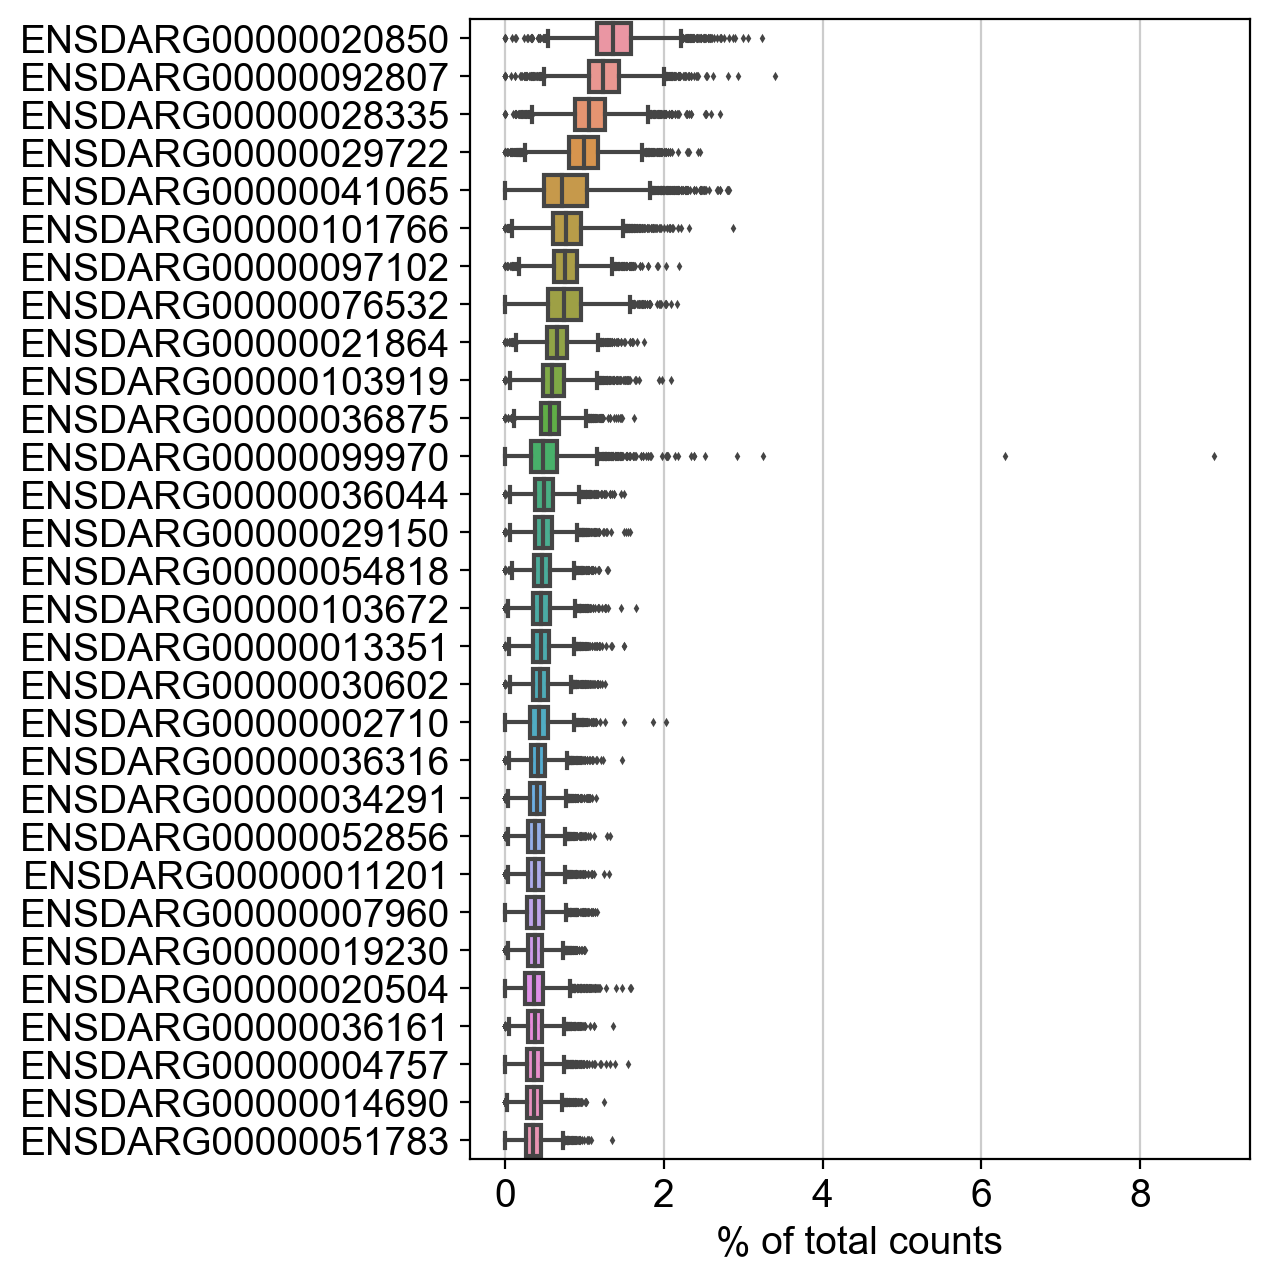

In [6]:
sc.pl.highest_expr_genes(adata, n_top=30)

In [7]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

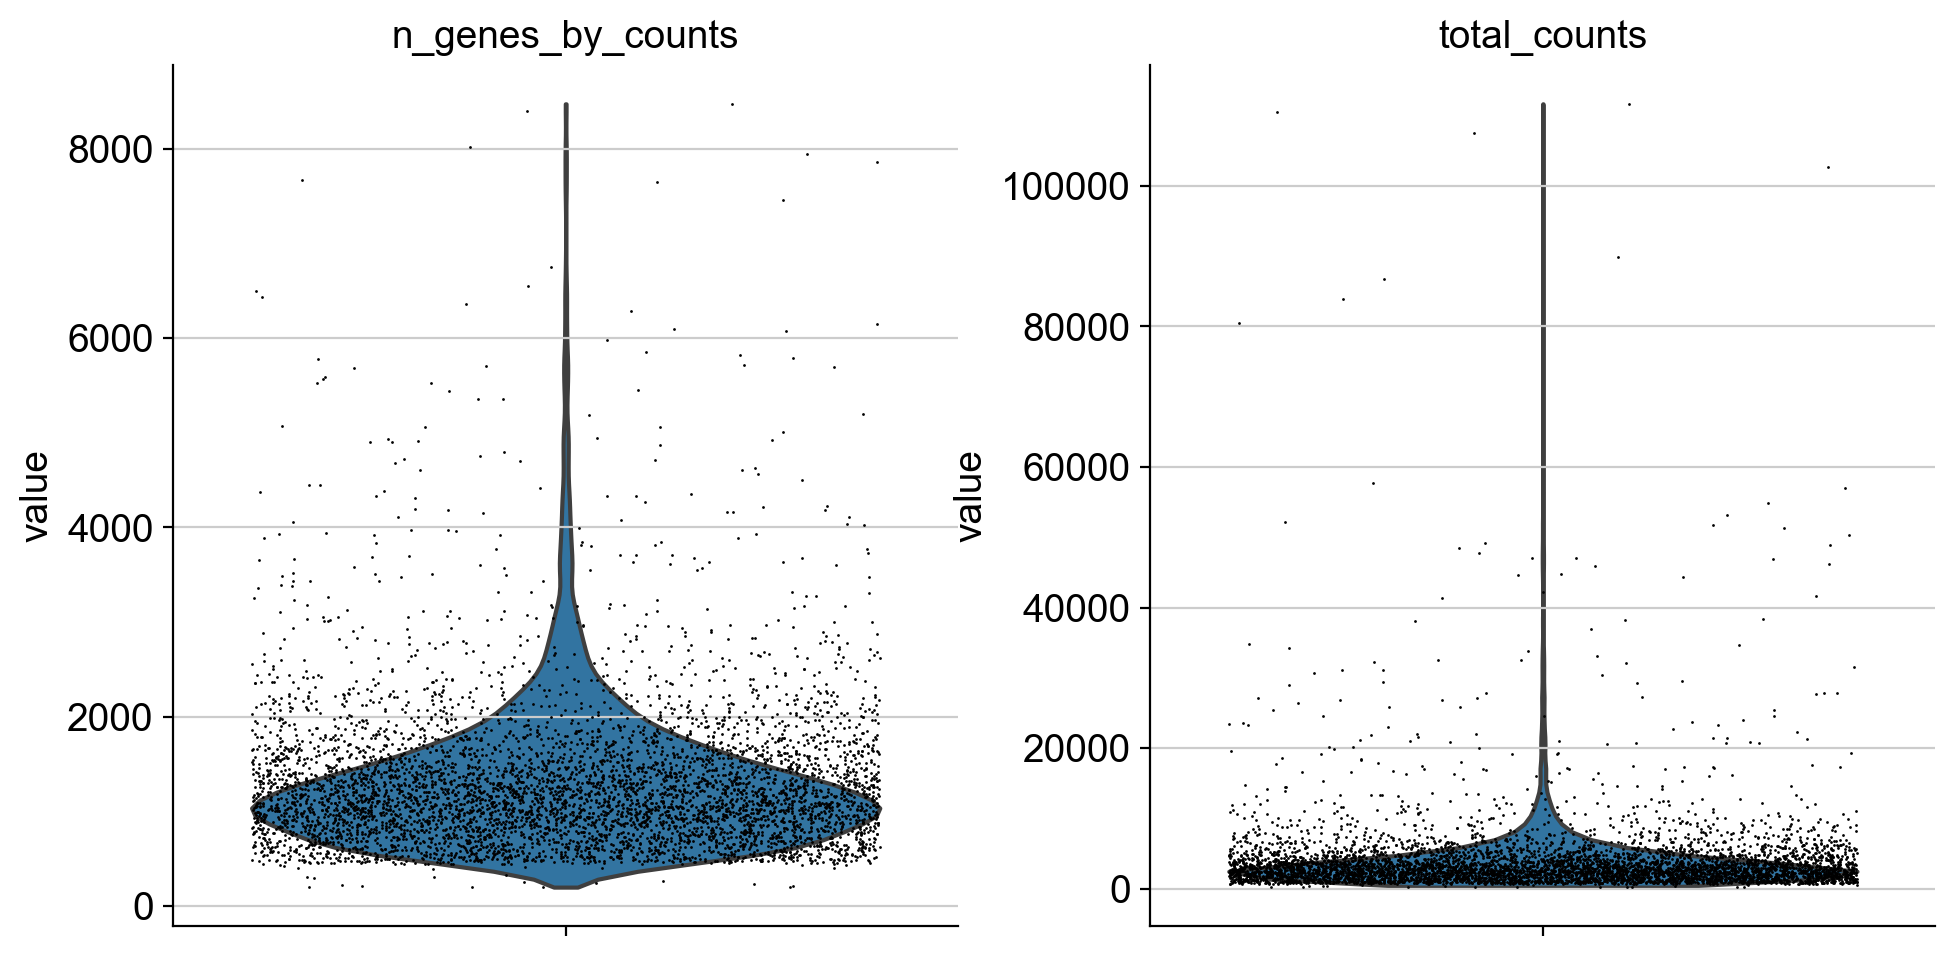

In [8]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, multi_panel=True)

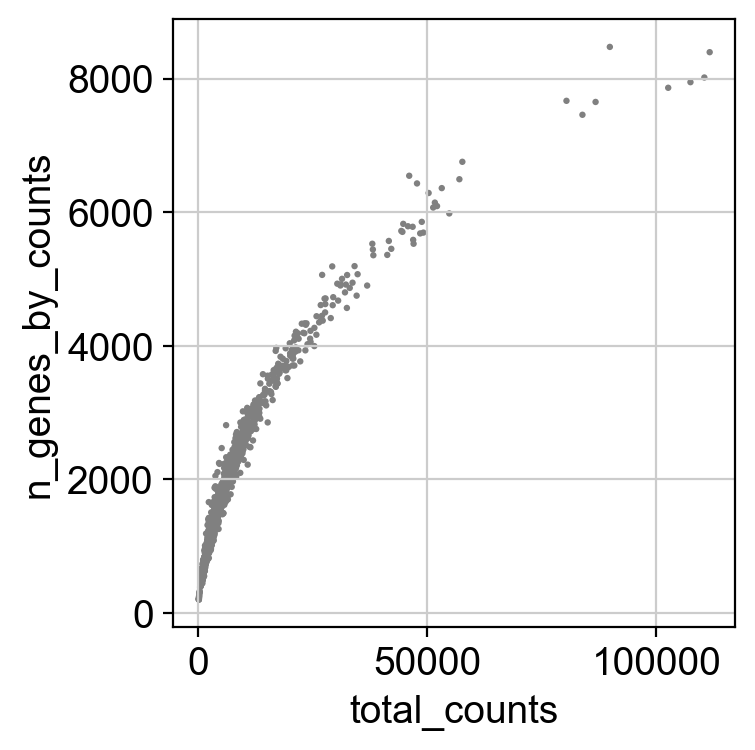

In [9]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [10]:
adata = adata[adata.obs.n_genes_by_counts < 6000, :]
# adata = adata[adata.obs.pct_counts_mt < 40, :]

In [11]:
sc.pp.normalize_total(adata, target_sum=1e4)

/Users/jonwells/miniconda3/envs/scanpy_env/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [12]:
sc.pp.log1p(adata)

In [13]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

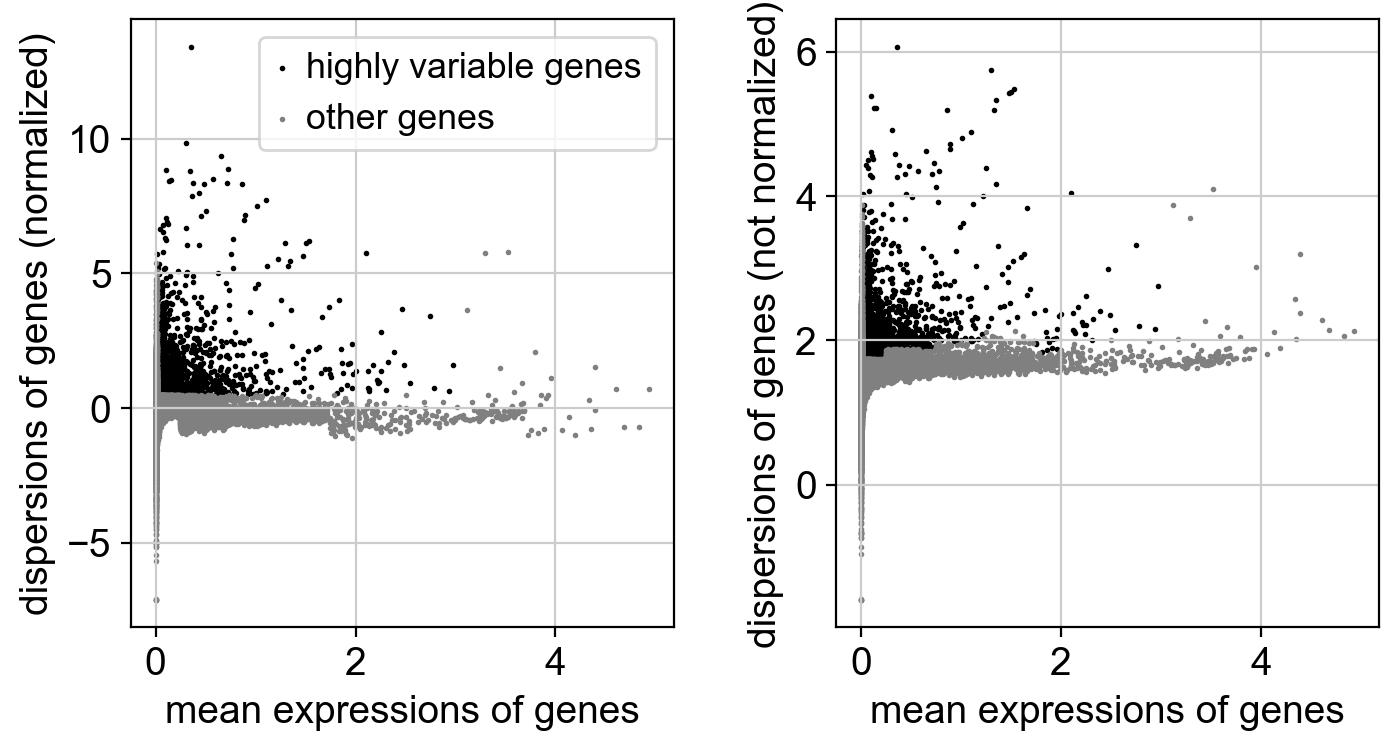

In [14]:
sc.pl.highly_variable_genes(adata)

In [15]:
adata.raw = adata

In [16]:
adata = adata[:, adata.var.highly_variable]

In [17]:
# sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

In [18]:
sc.pp.scale(adata, max_value=10)

/Users/jonwells/miniconda3/envs/scanpy_env/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [19]:
sc.tl.pca(adata, svd_solver='arpack')

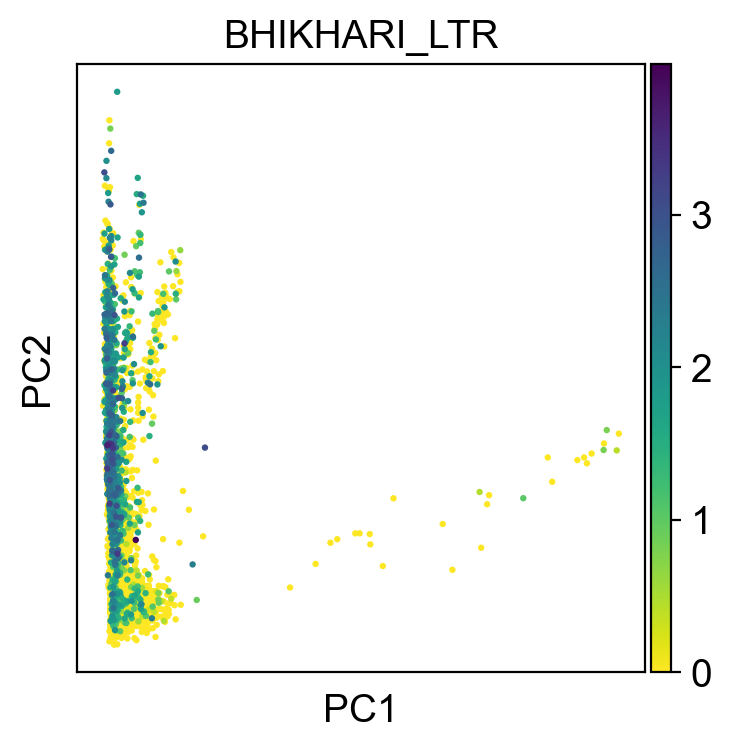

In [21]:
sc.pl.pca(adata, color='BHIKHARI_LTR')

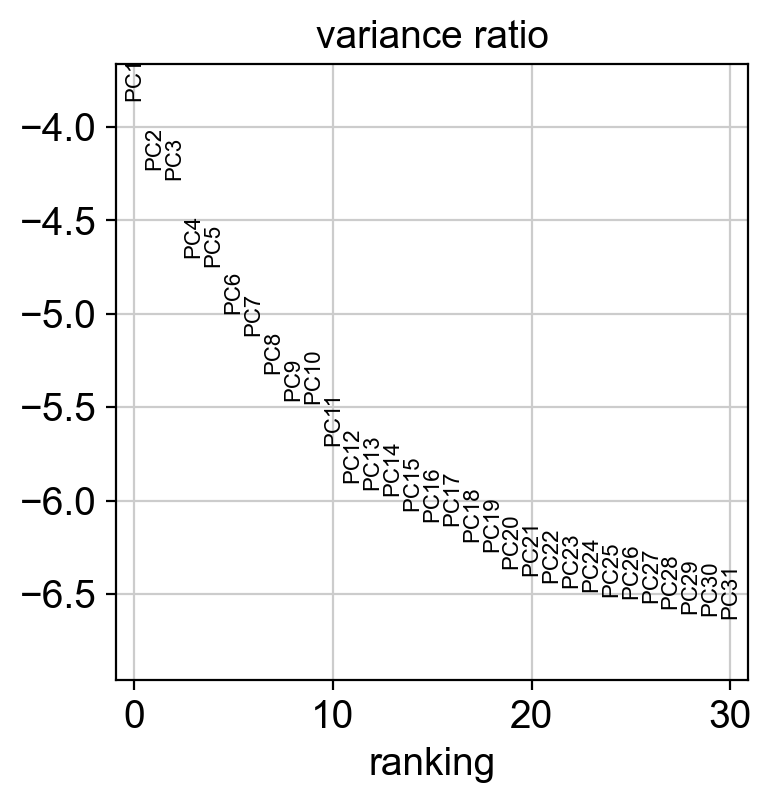

In [22]:
sc.pl.pca_variance_ratio(adata, log=True)

In [23]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

/Users/jonwells/miniconda3/envs/scanpy_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
sc.tl.louvain(adata)
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

In [25]:
sc.tl.umap(adata)

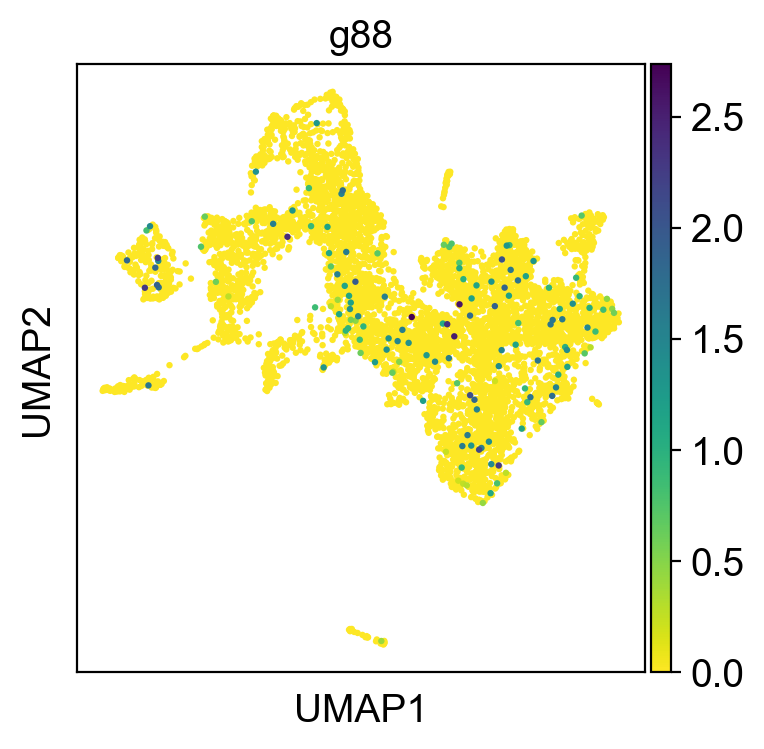

In [26]:
sc.pl.umap(adata, color=['g88'])

major


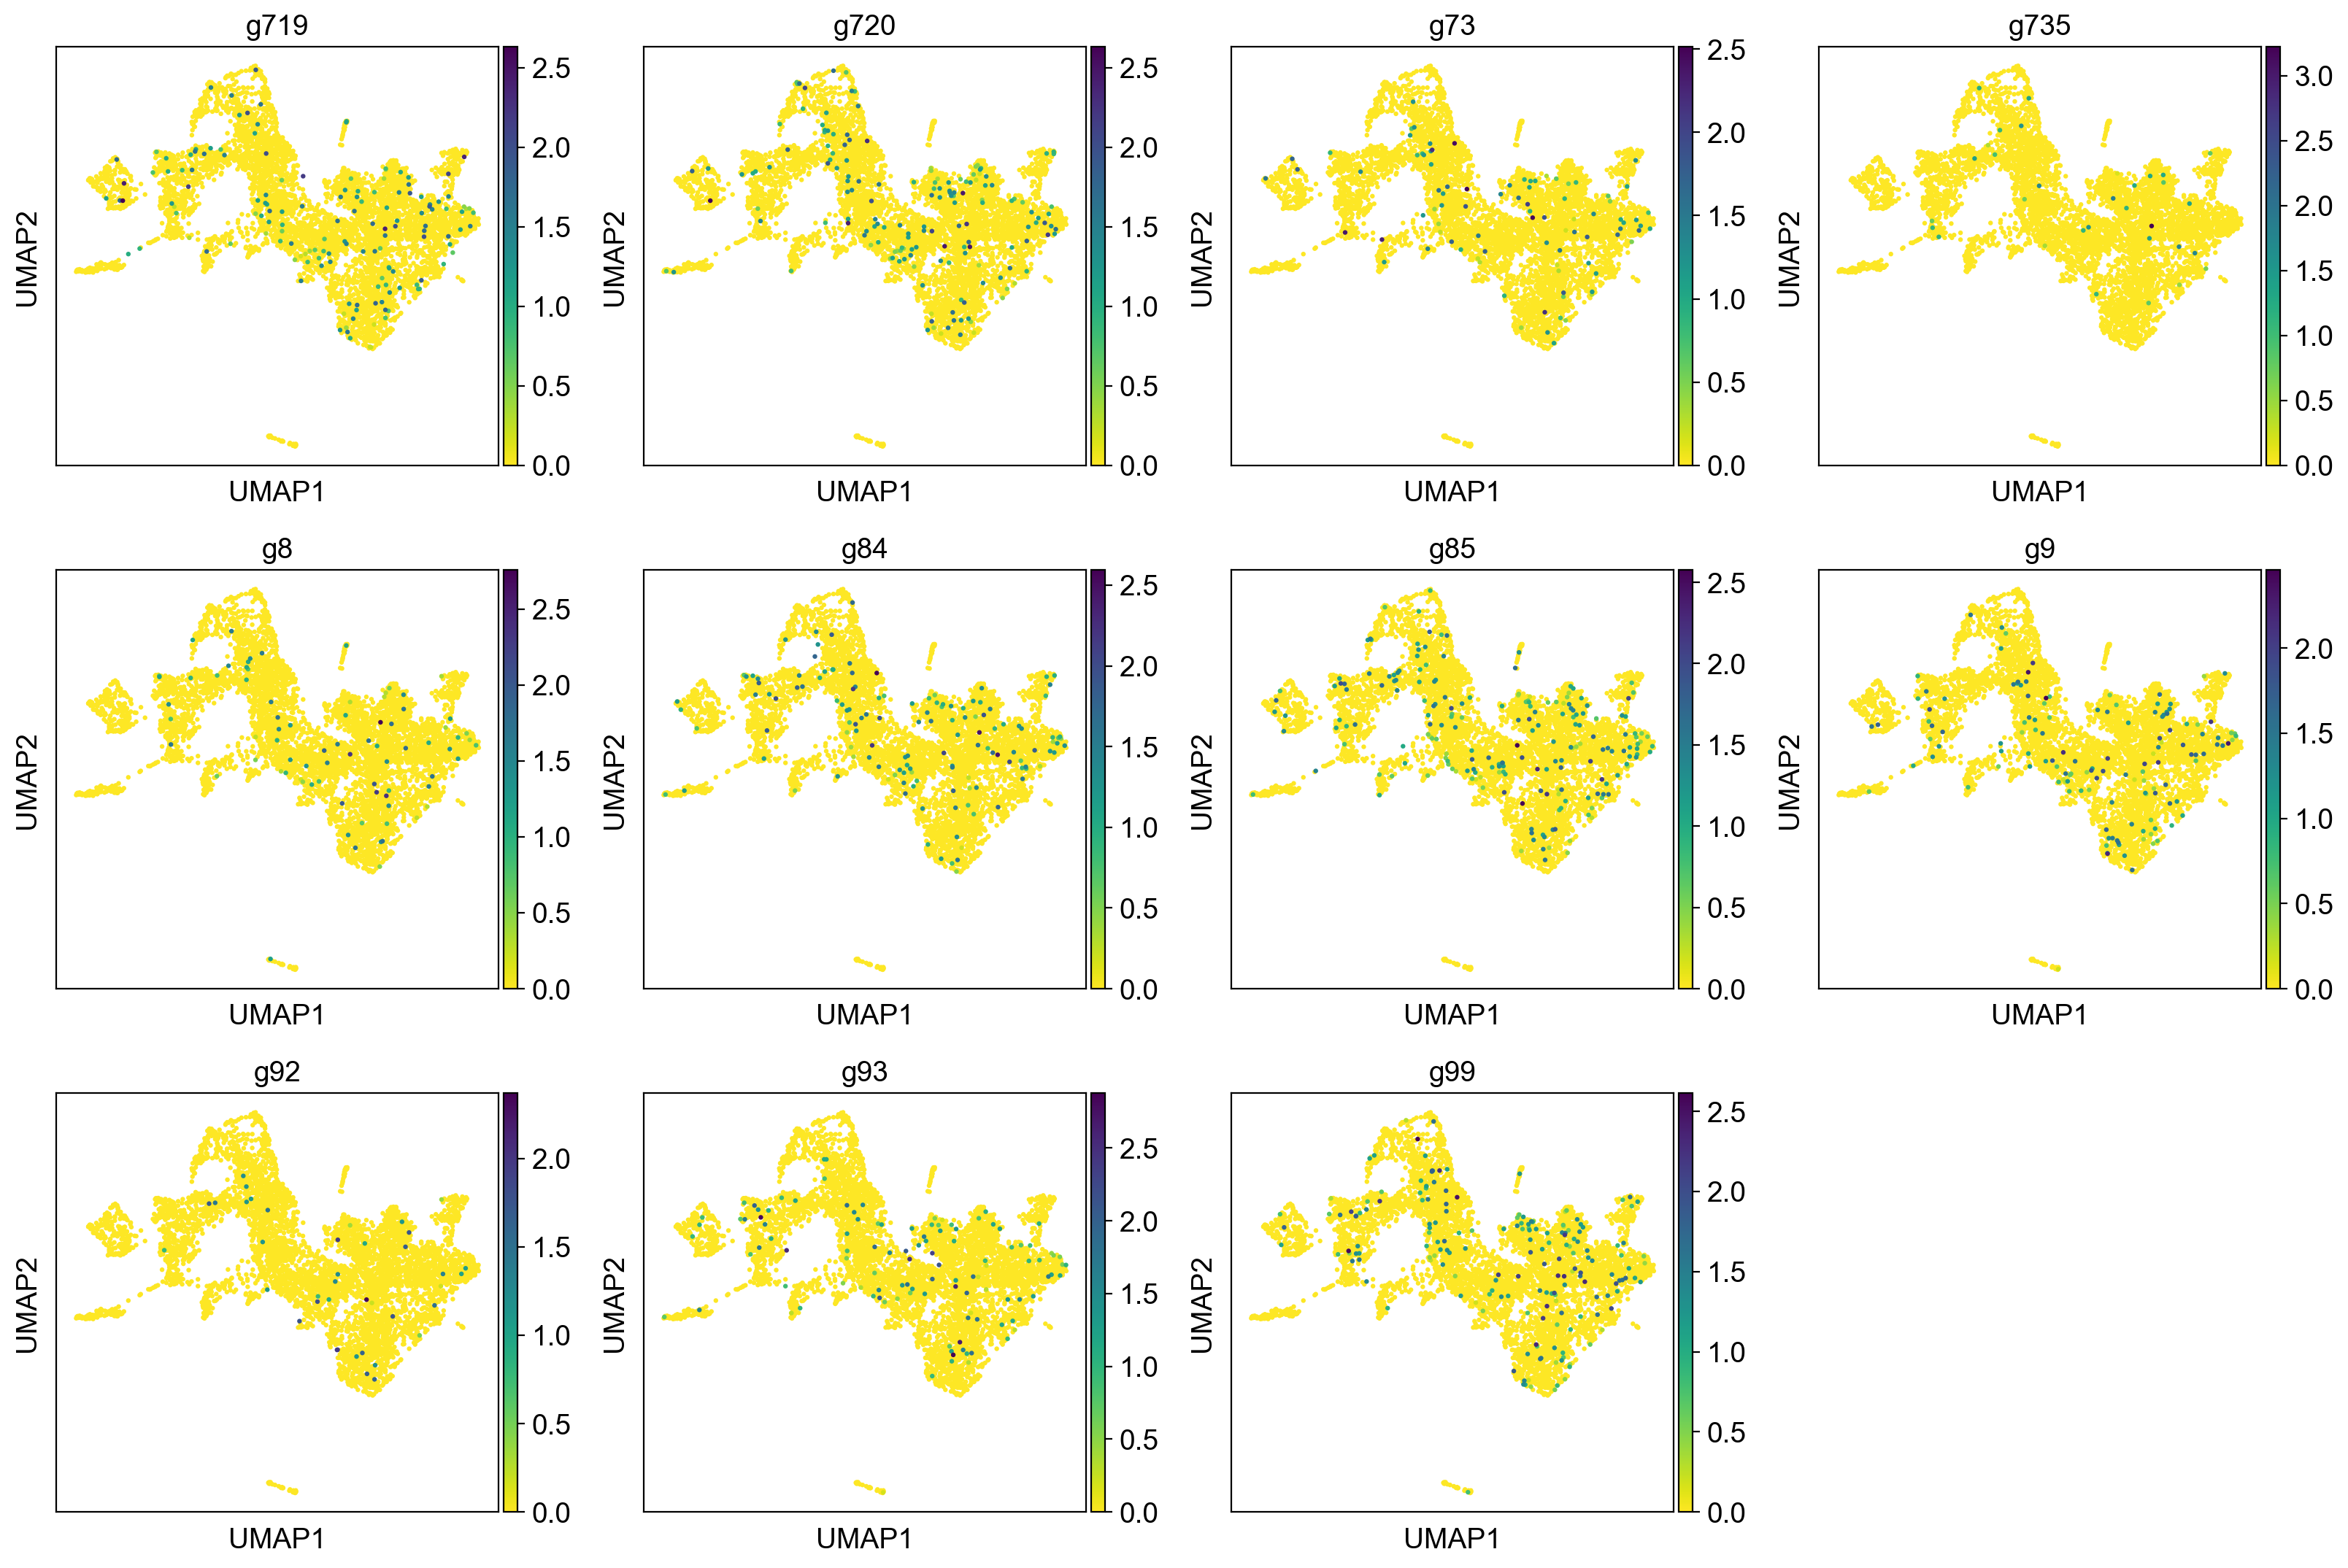

minor


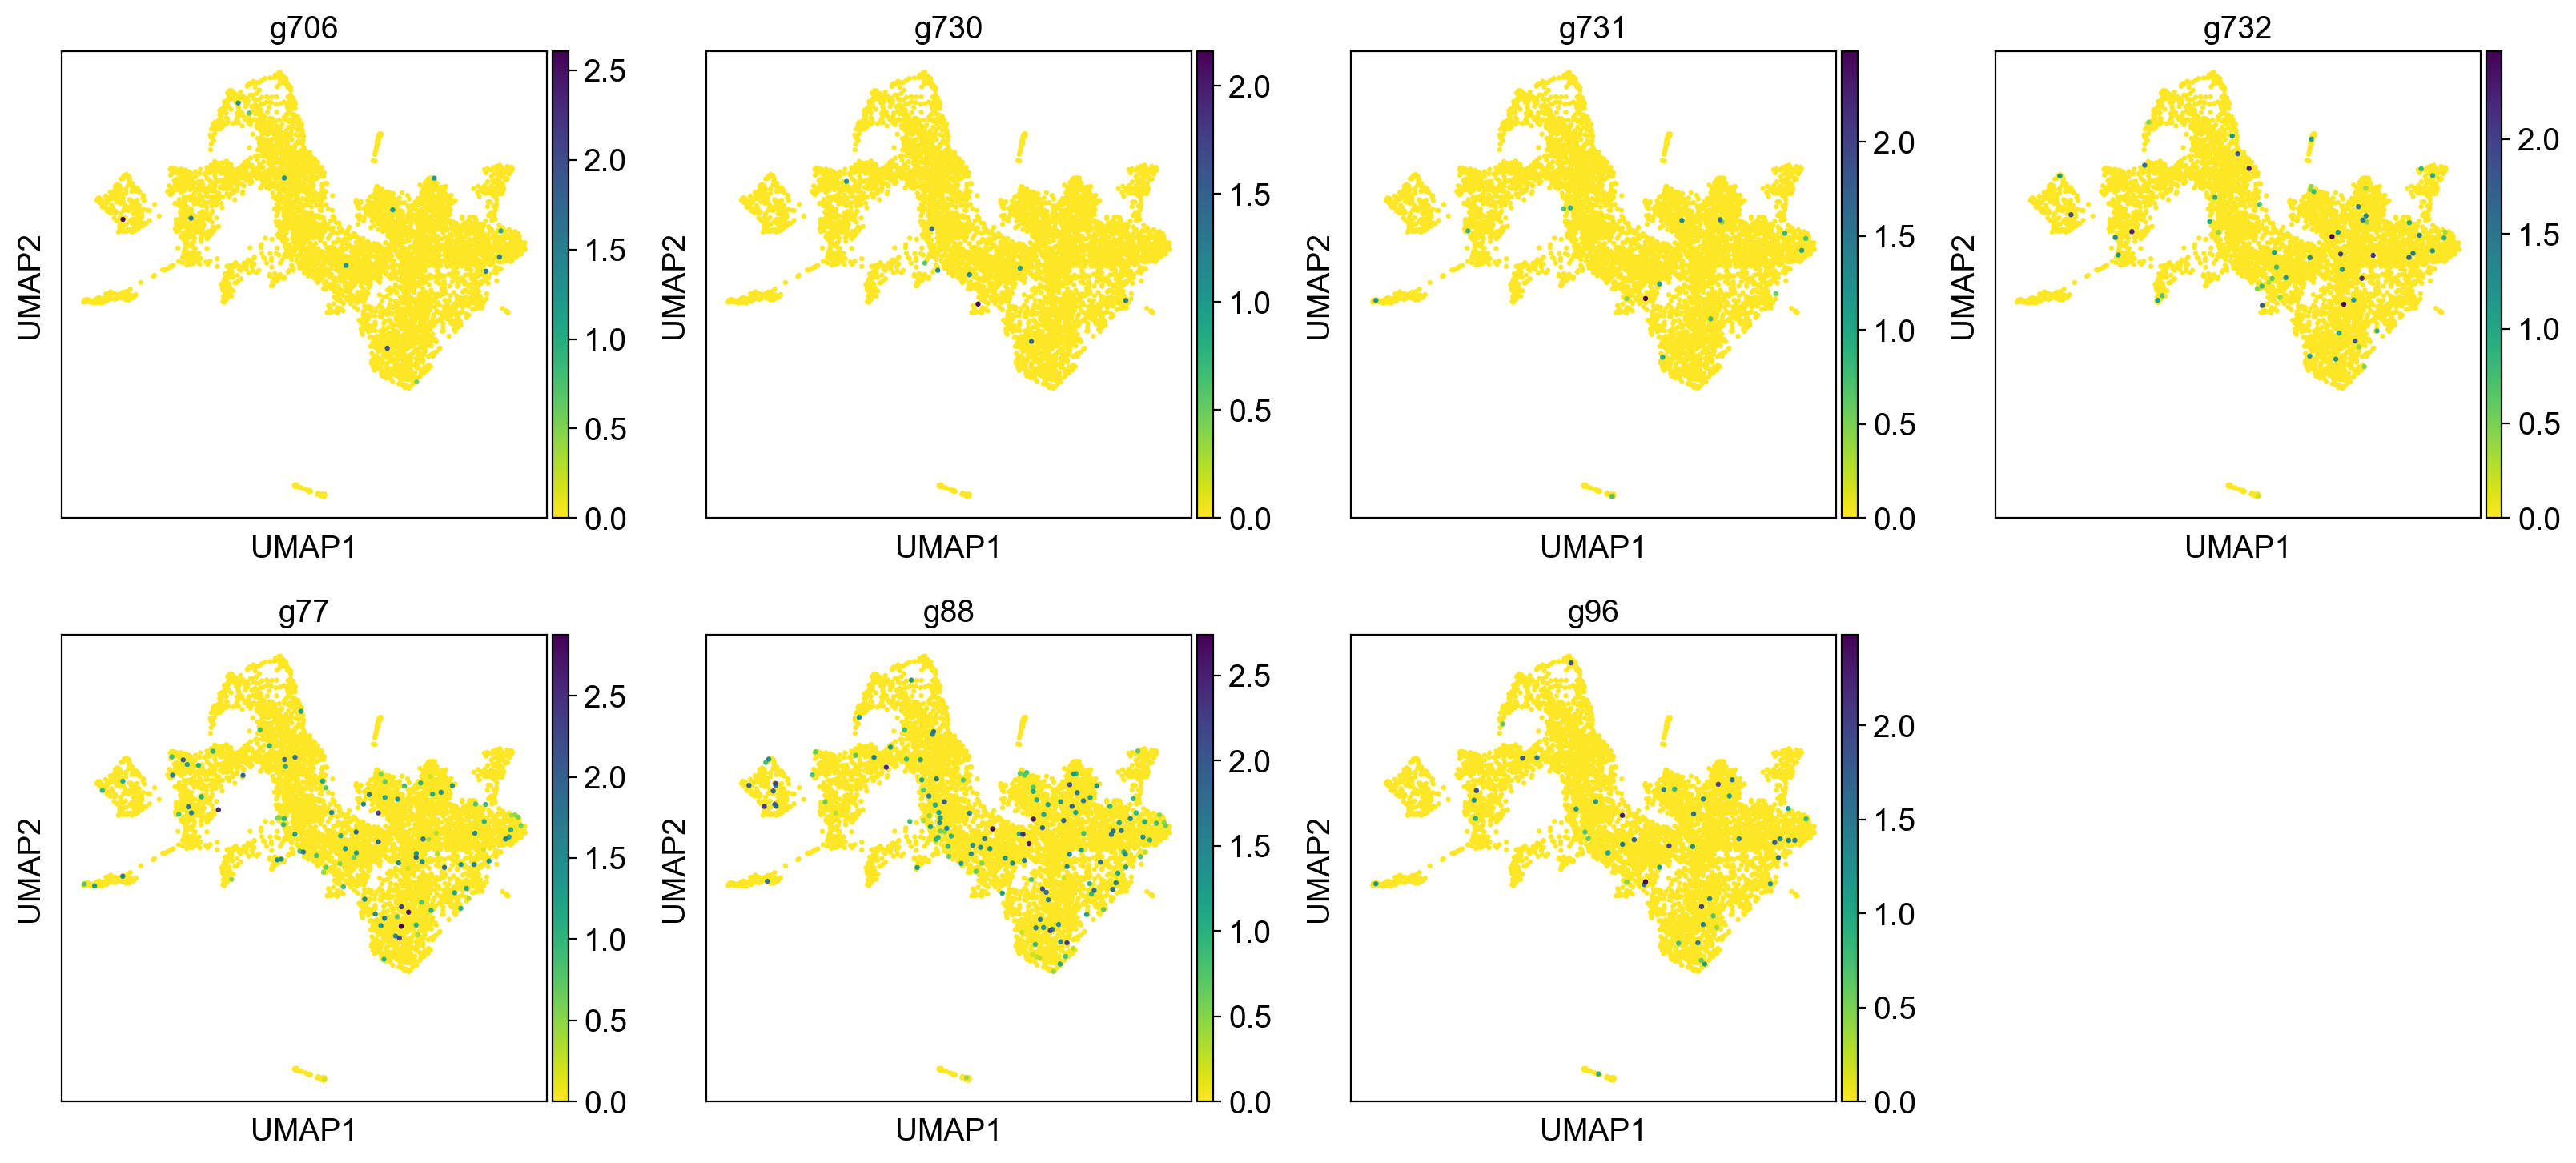

md


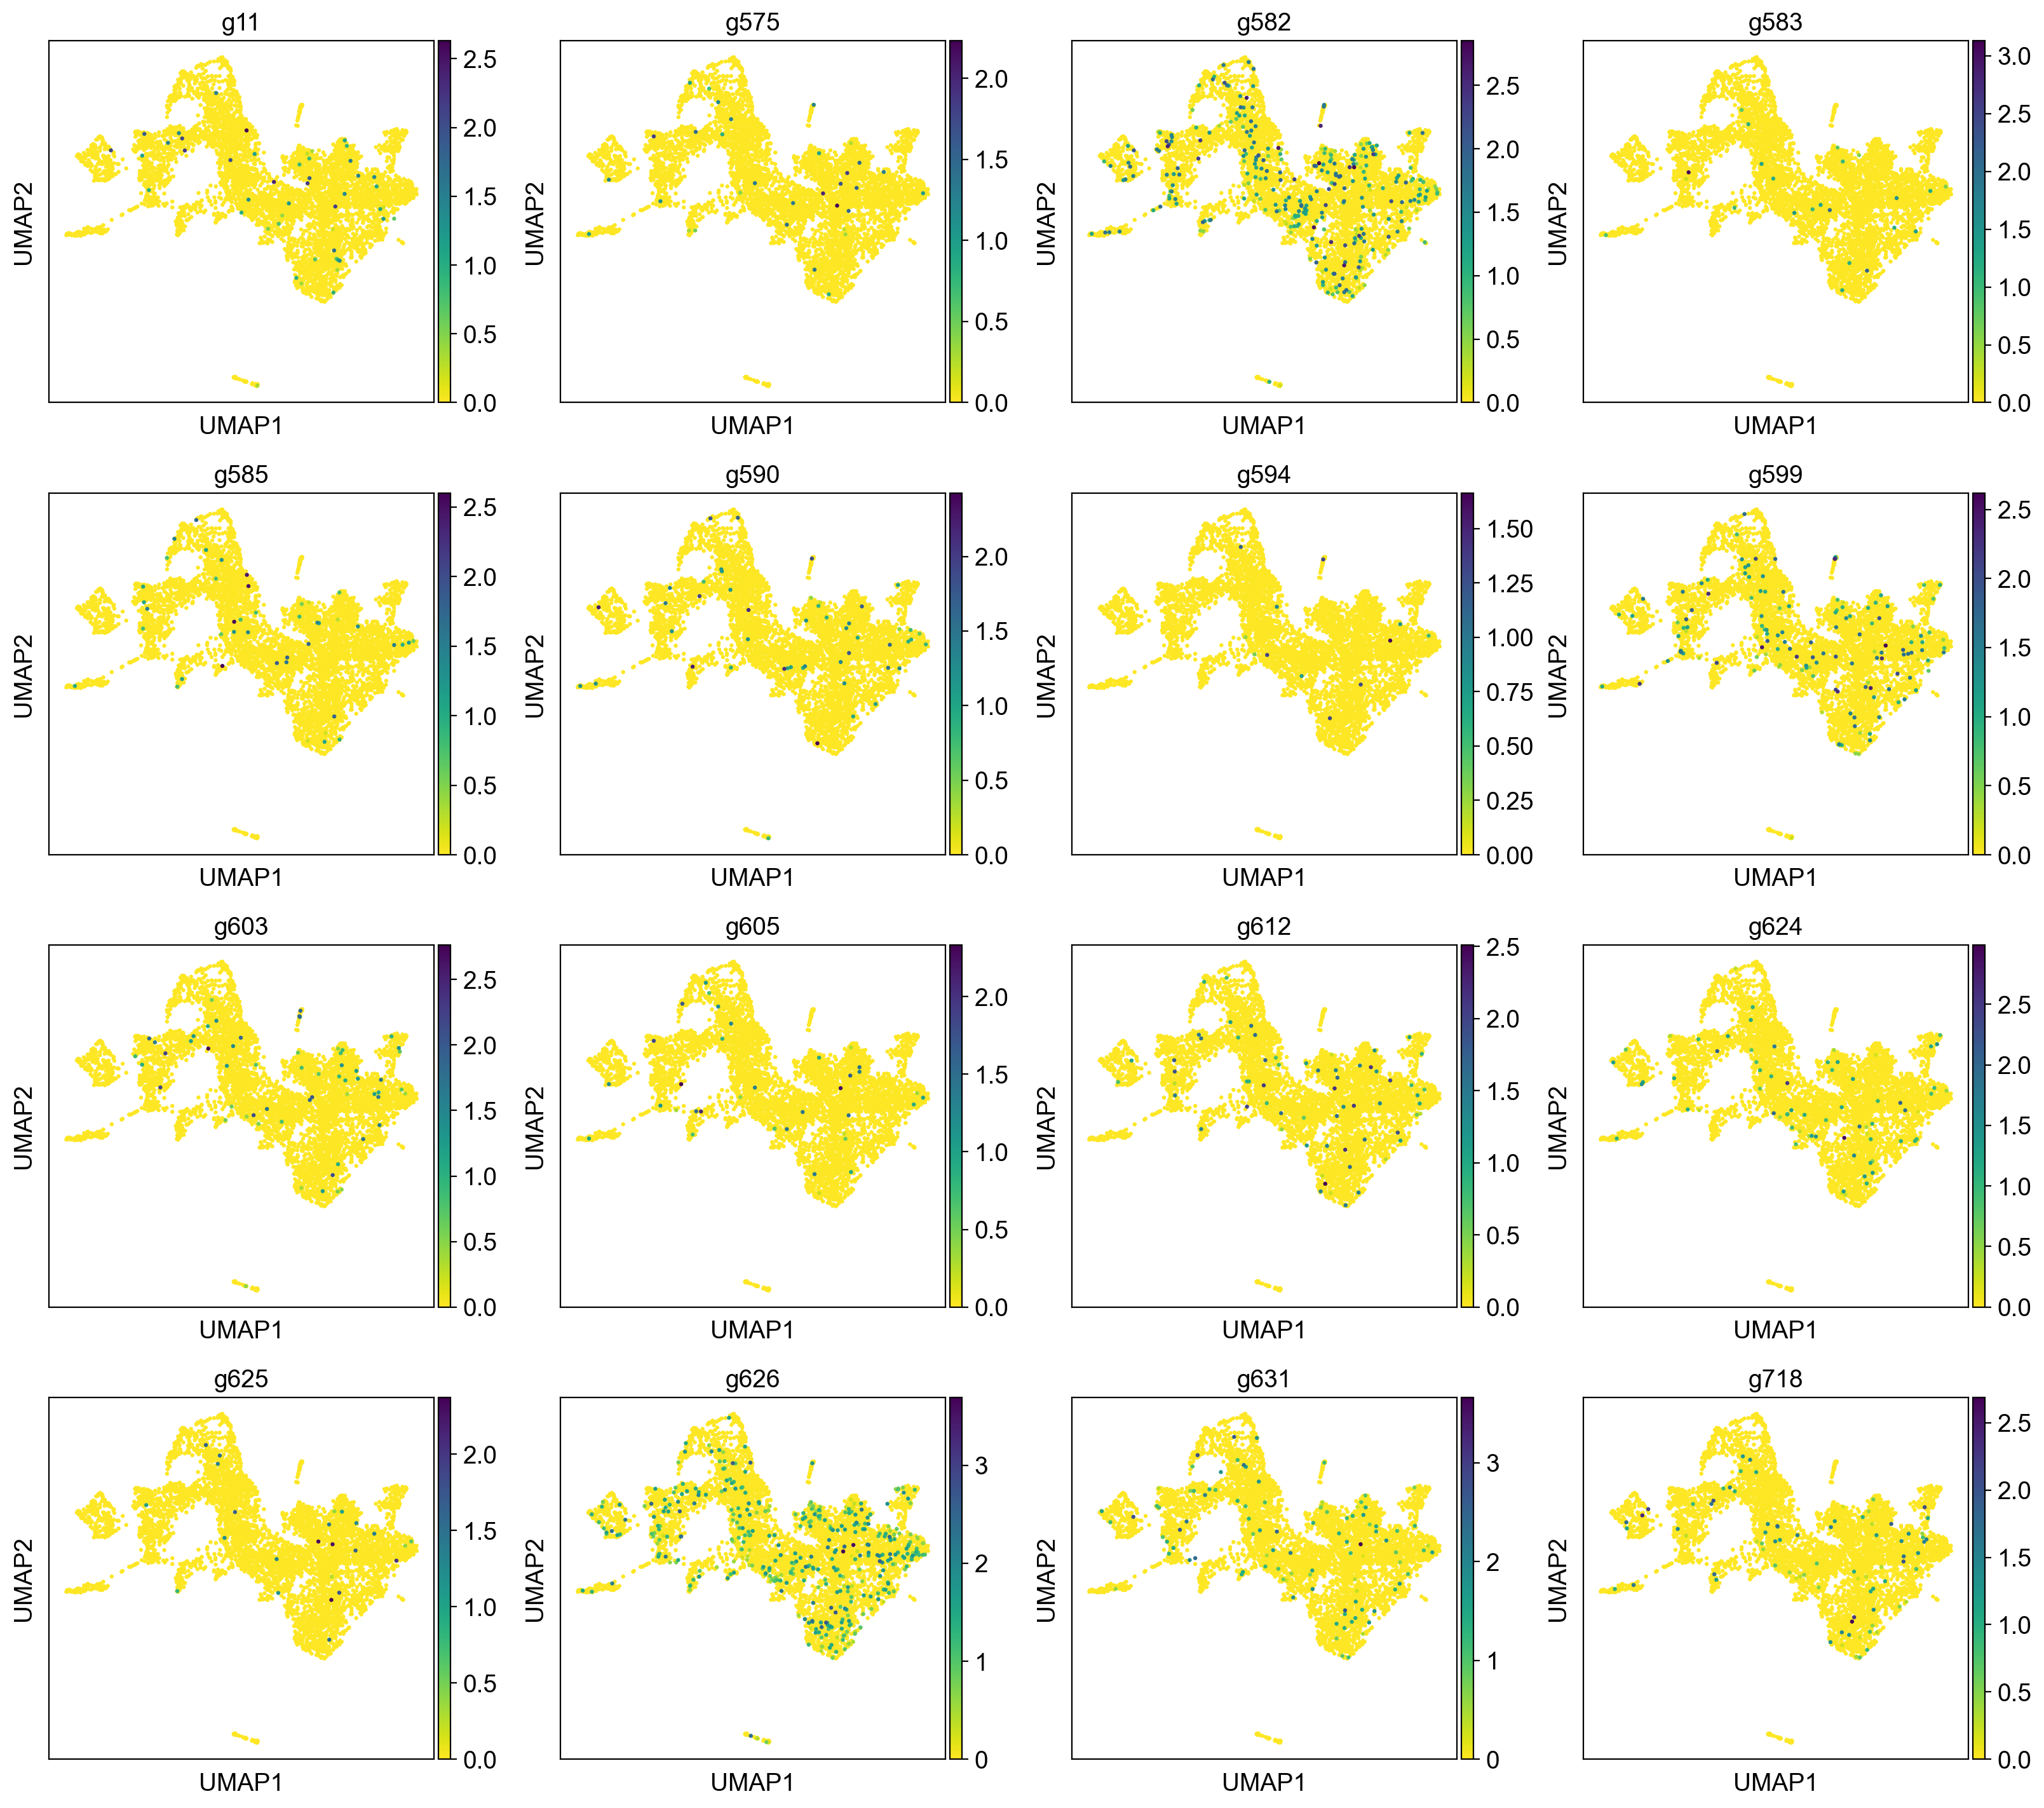

In [27]:
minor=[
    'g706',
    'g730',
    'g731',
    'g732',
    'g77',
    'g88',
    'g96'
      ]
major=[
    'g719',
    'g720',
    'g73',
    'g735',
    'g8',
    'g84',
    'g85',
    'g9',
    'g92',
    'g93',
    'g99'
]
mat=[
    'g11',
    'g575',
    'g582',
    'g583',
    'g585',
    'g590',
    'g594',
    'g599',
    'g603',
    'g605',
    'g612',
    'g624',
    'g625',
    'g626',
    'g631',
    'g718'
]
print('major')
sc.pl.umap(adata, color=major, )
print('minor')
sc.pl.umap(adata, color=minor)
print('md')
sc.pl.umap(adata, color=mat)